# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
from transformers import BertConfig
from transformers import RobertaTokenizerFast

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Available GPUs:", physical_devices)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
sequence_len = 512
batch_size = 64

config = BertConfig(
    vocab_size=9,
    hidden_size=84,
    num_hidden_layers=2,
    num_attention_heads=6,
    intermediate_size=64,
    max_position_embeddings=sequence_len,
    num_labels=31
)

epochs = 50

# Load & Prepare the data

In [4]:
all_data = pd.read_csv("../data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_ that are more than 30
all_data = all_data[[steps_ < 31 for steps_ in all_data['RI_steps_num']]]

print(f"max steps count: {max(all_data['RI_steps_num'])}")
print(f"min steps count: {min(all_data['RI_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
y_test = all_data["RI_steps_num"].tolist()

print(f"Count testing samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count testing samples: 3431


In [5]:
all_data = pd.read_csv("../data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_ that are more than 30
all_data = all_data[[steps_ < 31 for steps_ in all_data['RI_steps_num']]]

print(f"max steps count: {max(all_data['RI_steps_num'])}")
print(f"min steps count: {min(all_data['RI_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
y_train = all_data["RI_steps_num"].tolist()

print(f"Count training samples: {len(y_train)}")

Count all terms: 44568

Count original terms: 44568

max steps count: 30
min steps count: 0
Count training samples: 34851


In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("../../transformers_to_lo_steps_prediciton/fine_models", max_len=sequence_len)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
x_train = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_train]
x_test = [x_.replace("@x.", "y").replace(" ", "") for x_ in x_test]

train_df = pd.DataFrame({"term_str": x_train, "steps_ri": y_train})
test_df = pd.DataFrame({"term_str": x_test, "steps_ri": y_test})

label_encoder = {key_: [0.0] * 31 for key_ in range(31)}
for key_ in label_encoder.keys():
    label_encoder[key_][key_] = 1.0

def preprocess(example):
    # Tokenize the prompt
    tokenized_texts = tokenizer(example['term_str'].to_list(), truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")
    labels = tf.convert_to_tensor([label_encoder[key_] for key_ in example["steps_ri"]])
    return tokenized_texts, labels


tokenized_train_data = preprocess(train_df)
tokenized_test_data = preprocess(test_df)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_train_data[0]), tokenized_train_data[1])).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(tokenized_test_data[0]), tokenized_test_data[1])).batch(batch_size)

# Define the model

In [9]:
from transformers import TFBertModel
from keras.layers import Dense, Input, Flatten, AveragePooling1D, Dropout
from keras.models import Model

bert = TFBertModel(config=config)
bert.build()

input_ids_in = Input(shape=(sequence_len,), name='input_ids', dtype='int32')
input_masks_in = Input(shape=(sequence_len,), name='attention_mask', dtype='int32')

embedding_layer = bert(input_ids_in, attention_mask=input_masks_in)[0]
outputs = AveragePooling1D(pool_size=50)(embedding_layer)
outputs = Flatten()(outputs)
outputs = Dropout(rate=0.1)(outputs)
outputs = Dense(units=31, activation="softmax")(outputs)
model = Model(inputs=[input_ids_in, input_masks_in], outputs=outputs)

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  130832      ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [11]:
model_structure = model.to_json()
with open("./fine_models/transformer_model_ext.json", 'w') as json_file:
    json_file.write(model_structure)

In [12]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/transformer_model_ext.h5',  # Specify the path to save the best model
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [13]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/50
545/545 [==============================] - 111s 197ms/step - loss: 2.7444 - accuracy: 0.1279 - val_loss: 2.4931 - val_accuracy: 0.1638
Epoch 2/50
545/545 [==============================] - 105s 193ms/step - loss: 2.5157 - accuracy: 0.1556 - val_loss: 2.4135 - val_accuracy: 0.1760
Epoch 3/50
545/545 [==============================] - 105s 192ms/step - loss: 2.4469 - accuracy: 0.1706 - val_loss: 2.3509 - val_accuracy: 0.1938
Epoch 4/50
545/545 [==============================] - 104s 191ms/step - loss: 2.4054 - accuracy: 0.1760 - val_loss: 2.3132 - val_accuracy: 0.2052
Epoch 5/50
545/545 [==============================] - 103s 190ms/step - loss: 2.3791 - accuracy: 0.1824 - val_loss: 2.3053 - val_accuracy: 0.2029
Epoch 6/50
545/545 [==============================] - 103s 190ms/step - loss: 2.3521 - accuracy: 0.1890 - val_loss: 2.2782 - val_accuracy: 0.2192
Epoch 7/50
545/545 [==============================] - 103s 189ms/step - loss: 2.3351 - accuracy: 0.1902 - val_loss: 2.2818 -

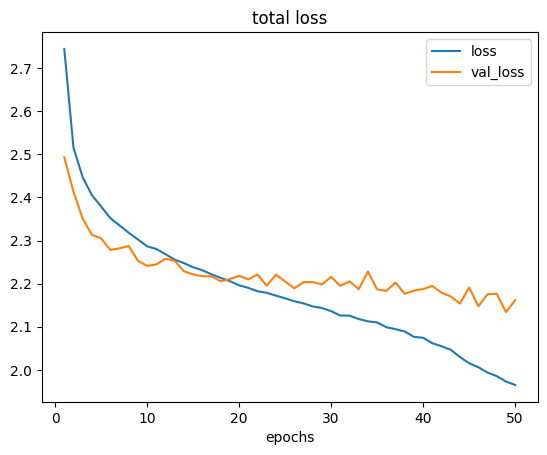

In [14]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

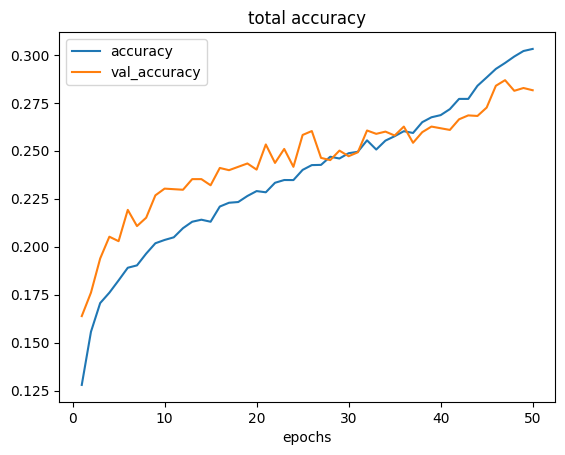

In [15]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [16]:
def draw_pred_lines(y_pred, y_real, title="Train dataset", axis_name="RI Steps"):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel(f"Count {axis_name}")
    plt.title(title)
    plt.legend()
    plt.show()


def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [17]:
# load the model
from transformers import TFBertModel

with open("./fine_models/transformer_model.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"TFBertModel": TFBertModel})
model.load_weights("./fine_models/transformer_model.h5")

54/54 [==============================] - 5s 69ms/step
Test accuracy: 0.18595161760419704


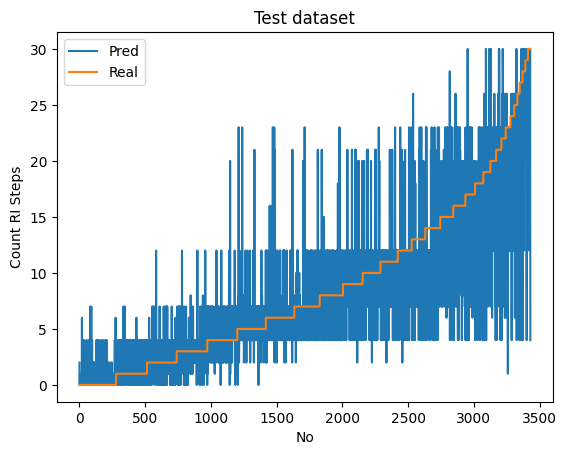

In [18]:
y_test_pred = model.predict(test_dataset)

y_test_pred_nums = [np.argmax(x_) for x_ in y_test_pred]
y_test_nums = y_test

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
draw_pred_lines(y_test_pred_nums, y_test_nums, title="Test dataset", axis_name="RI Steps")

545/545 [==============================] - 37s 67ms/step
Train accuracy: 0.15023959140340307


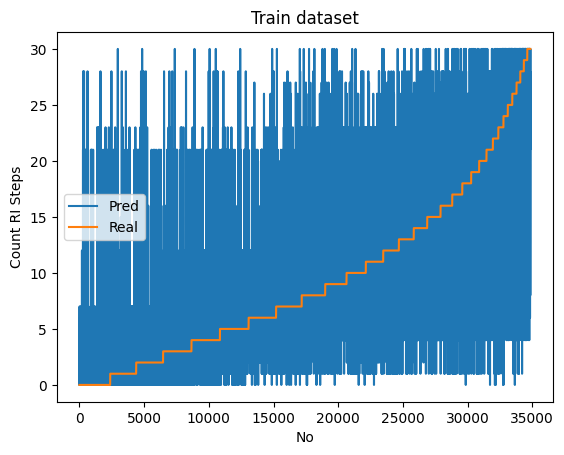

In [19]:
y_train_pred = model.predict(train_dataset)

y_train_pred_nums = [np.argmax(x_) for x_ in y_train_pred]
y_train_nums = y_train

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
draw_pred_lines(y_train_pred_nums, y_train_nums, title="Train dataset", axis_name="RI Steps")

In [20]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    simple_str = term.simple_str()
    simple_str = simple_str.replace("@x.", "y").replace(" ", "")

    tokenized_texts = tokenizer([simple_str], truncation=True, padding='max_length', max_length=sequence_len, return_tensors="tf")

    prediction_ = model_.predict([tokenized_texts["input_ids"], tokenized_texts["attention_mask"]], verbose=0)
    print(f"{term_deskr_}\nnorm_steps={term_.normalize(RIStrategy())[1]}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (
term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10,
term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=inf	pred_steps=4

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	pred_steps=7

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	pred_steps=7

(PRED 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=4

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=15	pred_steps=7

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=4

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=13	pred_steps=4

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=39	pred_steps=7

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=30	pred_steps=12

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=37	pred_steps=12

(EQ 2 2) == TRUE == λx. λy. x
norm_steps=79	pred_steps=20

(EQ 1 4) == FALSE == λx. λy. y
norm_steps=84	pred_steps=20

Omega(3, 3)  == I == λx. x
norm_steps=5	pred_steps=4

GCD_vO 5 2
norm_steps=inf	pred_steps=30

GCD_v1 5 2
norm_steps=inf	pred_steps=30

GCD_v3 5 2
norm_steps=inf	pred_steps=30

PYTHAGOREAN 5 2 2
norm_steps=inf	pr

# Do additional metrics testing

## Mean Squared Error

In [21]:
mse_train = mean_squared_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 24.049094717511693
Test {Mean Squared Error}: 18.543573302244244


## Root Mean Squared Error

In [22]:
rmse_train = np.sqrt(mean_squared_error(y_train_nums, y_train_pred_nums))
print("Train {Root Mean Squared Error}:", rmse_train)

rmse_test = np.sqrt(mean_squared_error(y_test_nums, y_test_pred_nums))
print("Test {Root Mean Squared Error}:", rmse_test)

Train {Root Mean Squared Error}: 4.903987634314721
Test {Root Mean Squared Error}: 4.306224947938071


## Mean Absolute Error

In [23]:
mae_train = mean_absolute_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 3.30552925310608
Test {Mean Absolute Error}: 2.8746721072573593


## Coefficient of Correlation (Pearson's r)

In [24]:
coc_test = np.corrcoef(y_test_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.7727037021902179
Test {Mean Bias Deviation}: 0.8083374960512744


## Error STD

In [25]:
y_train_cl_pred_nums = np.array(y_train_pred_nums)
y_test_cl_pred_nums = np.array(y_test_pred_nums)

y_train_nums = np.array(y_train_nums)
y_test_nums = np.array(y_test_nums)
train_error = y_train_nums - y_train_cl_pred_nums
test_error = y_test_nums - y_test_cl_pred_nums
print("Train Error STD:", np.abs(train_error).std())
print("Test Error STD:", np.abs(test_error).std())

Train Error STD: 3.622508947452256
Test Error STD: 3.2062179554735164


# Some additional drawings

In [26]:
def advanced_point_drawer(y_real, y_pred, title="Train dataset", axis_name="LO Steps"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 5, c='tab:blue', label=f"\n{key_}\n")

    plt.plot([0, 31], [0, 31], c="gray", linestyle="--")
    plt.axis("equal")
    plt.xlabel(f"Real {axis_name}", fontsize=18)
    plt.ylabel(f"Predict {axis_name}", fontsize=18)
    plt.title(title, fontsize=20)
    plt.legend(prop={'size': 10})
    plt.show()

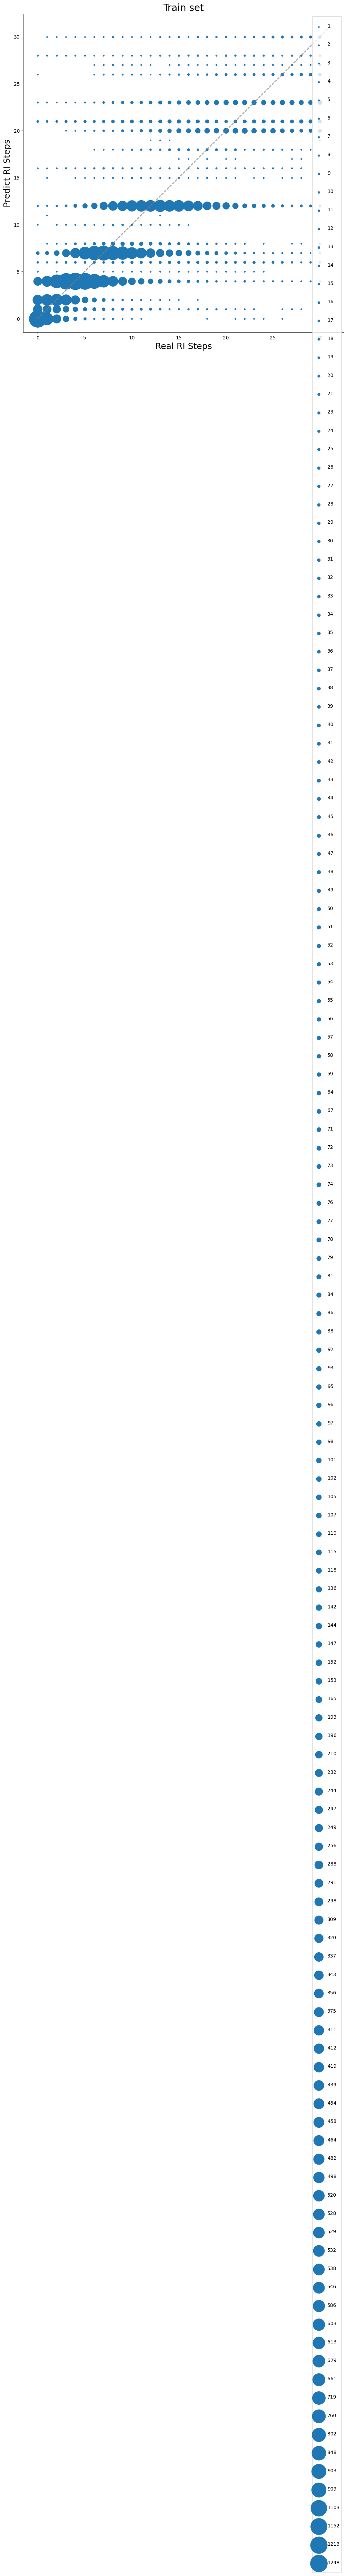

In [27]:
advanced_point_drawer(y_train_nums, y_train_cl_pred_nums, "Train set", "RI Steps")

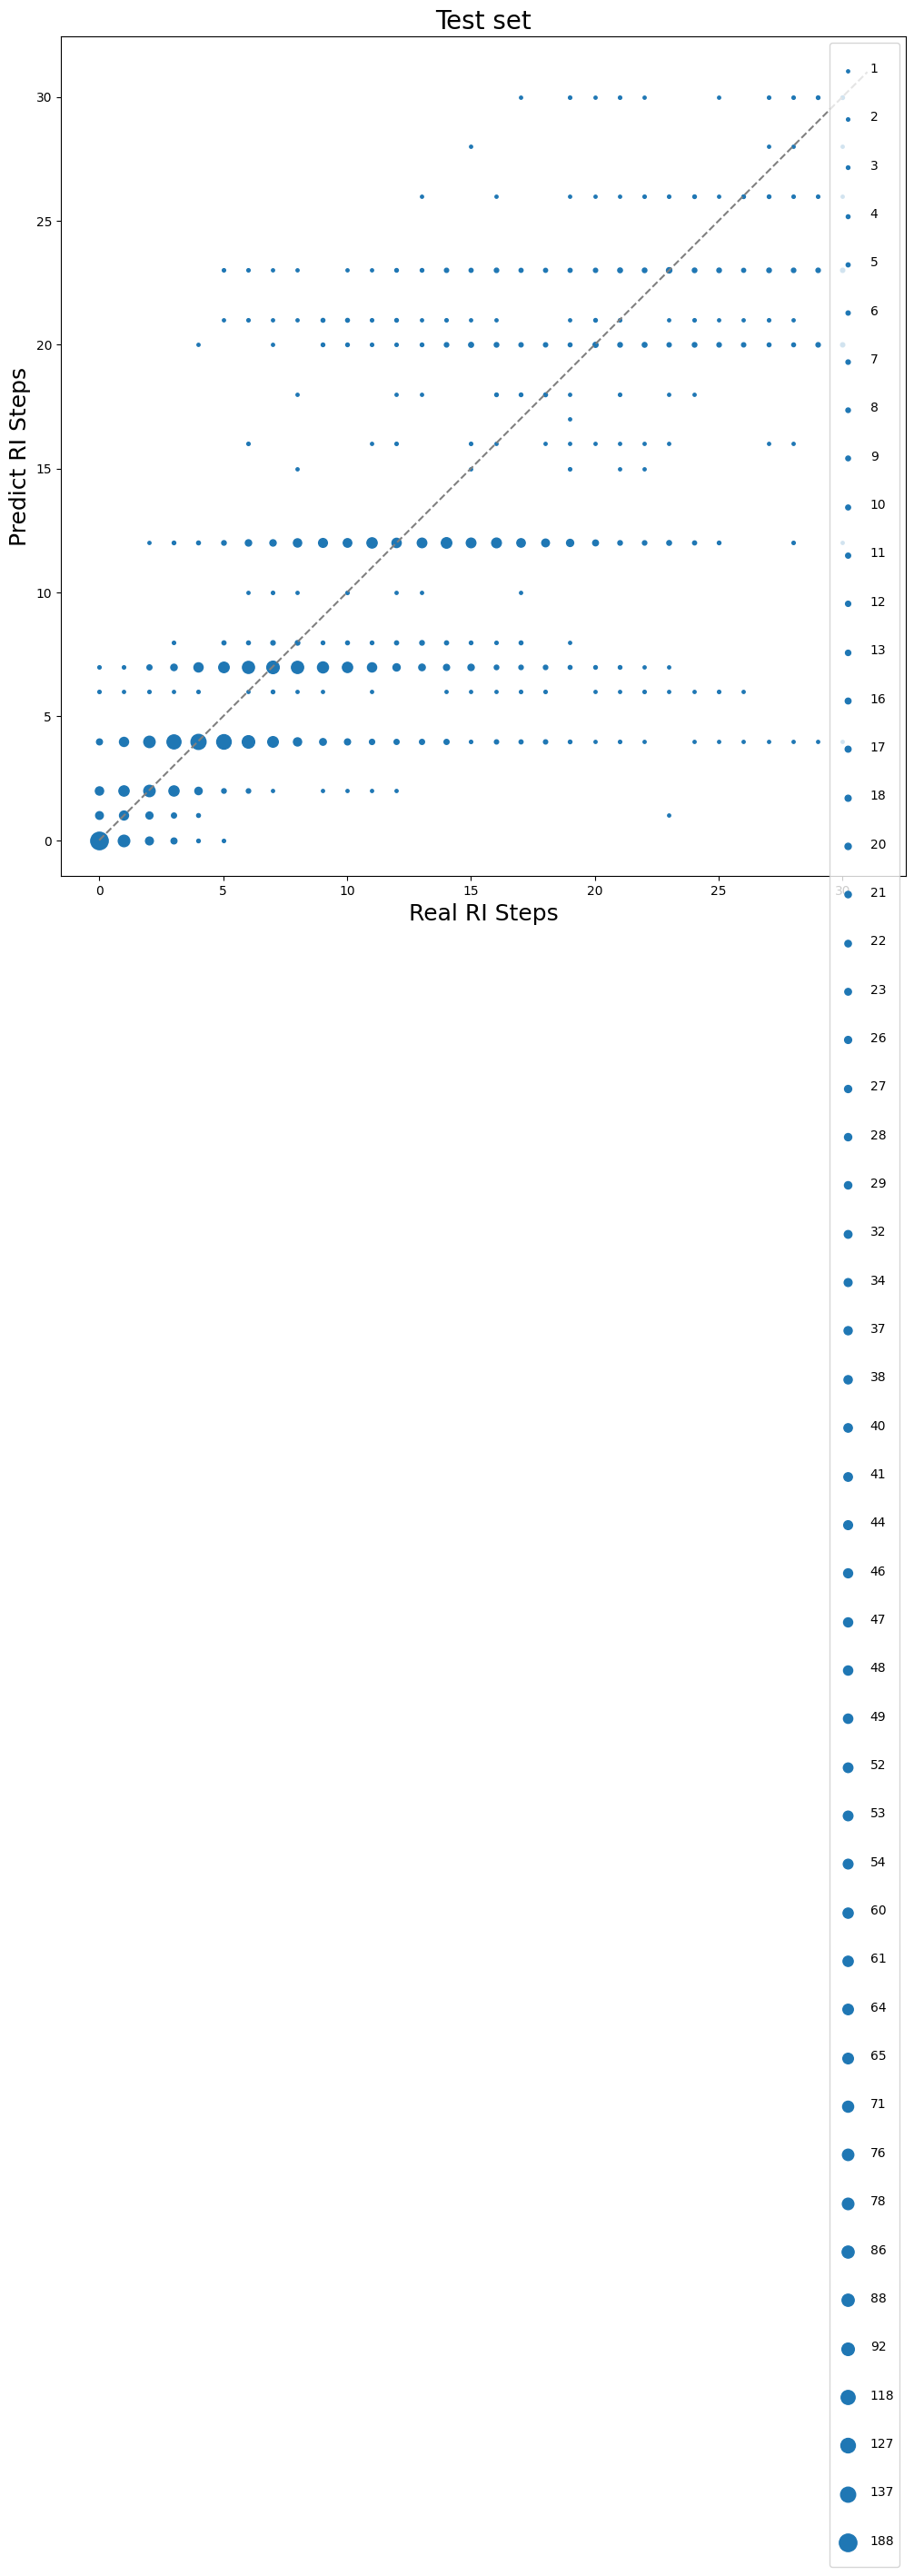

In [28]:
advanced_point_drawer(y_test_nums, y_test_cl_pred_nums, "Test set", "RI Steps")

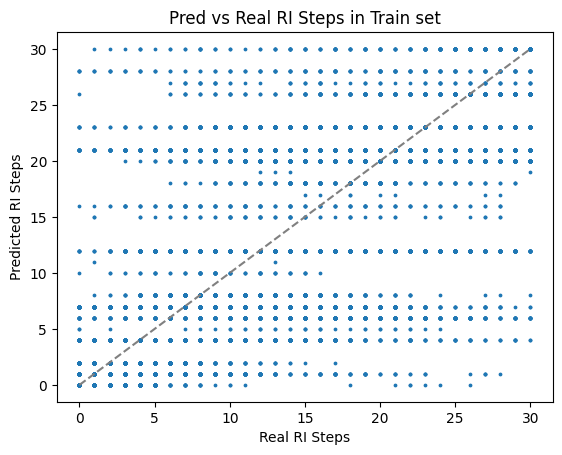

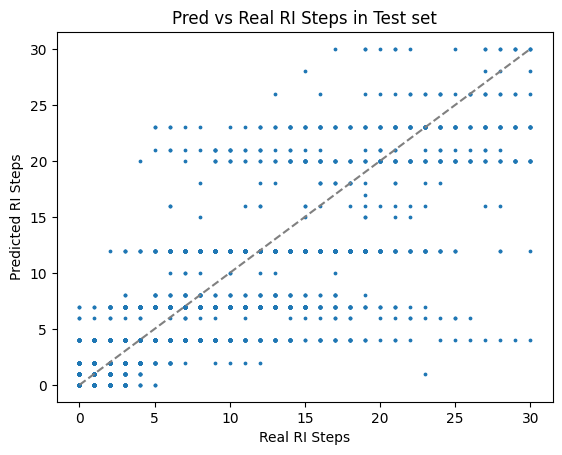

In [29]:
def draw_pred_scatter(y_real, y_pred, title="Train dataset", axis_name="RI Steps"):
    plt.scatter(y_real, y_pred, s=3)
    plt.plot([0, 30], [0, 30], color='gray', linestyle='--')

    plt.xlabel(f"Real {axis_name}")
    plt.ylabel(f"Predicted {axis_name}")
    plt.title(f"Pred vs Real {axis_name} in {title}")
    plt.show()


draw_pred_scatter(y_train_nums, y_train_cl_pred_nums, "Train set", "RI Steps")
draw_pred_scatter(y_test_nums, y_test_cl_pred_nums, "Test set", "RI Steps")

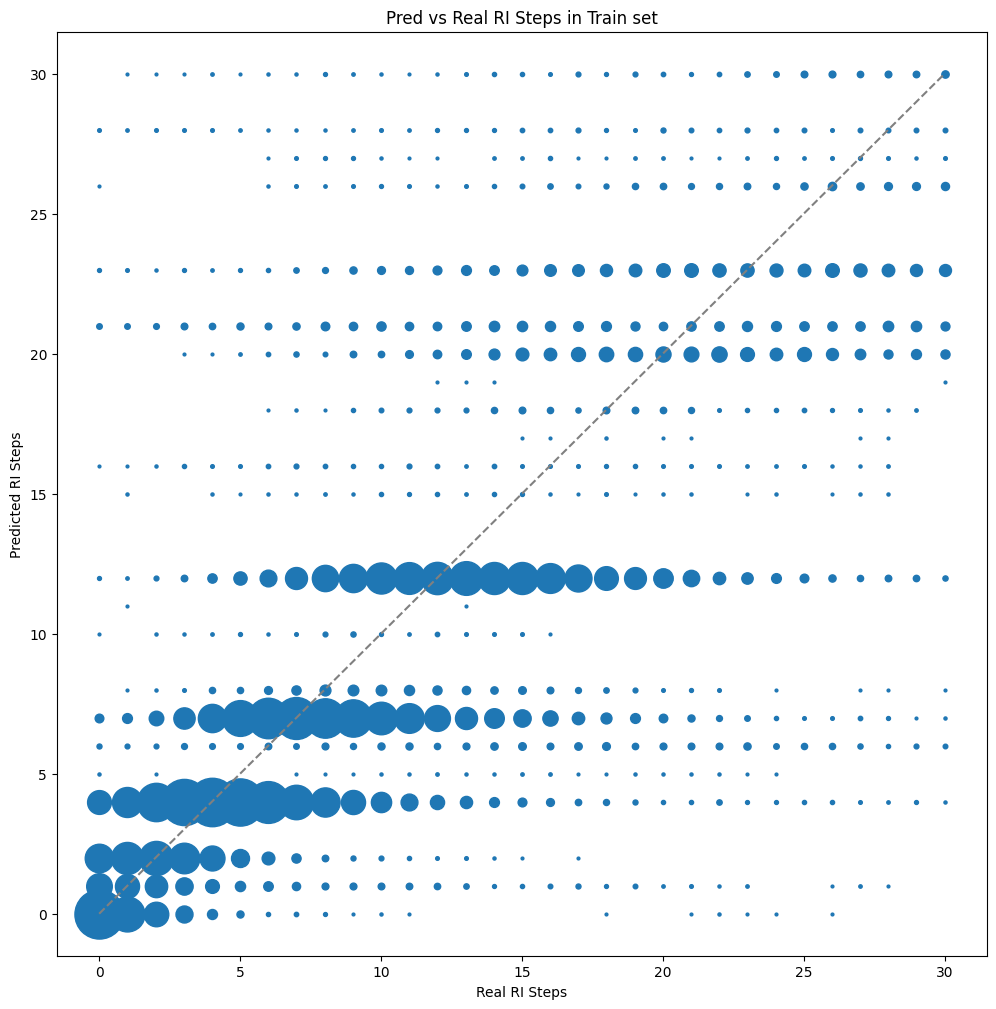

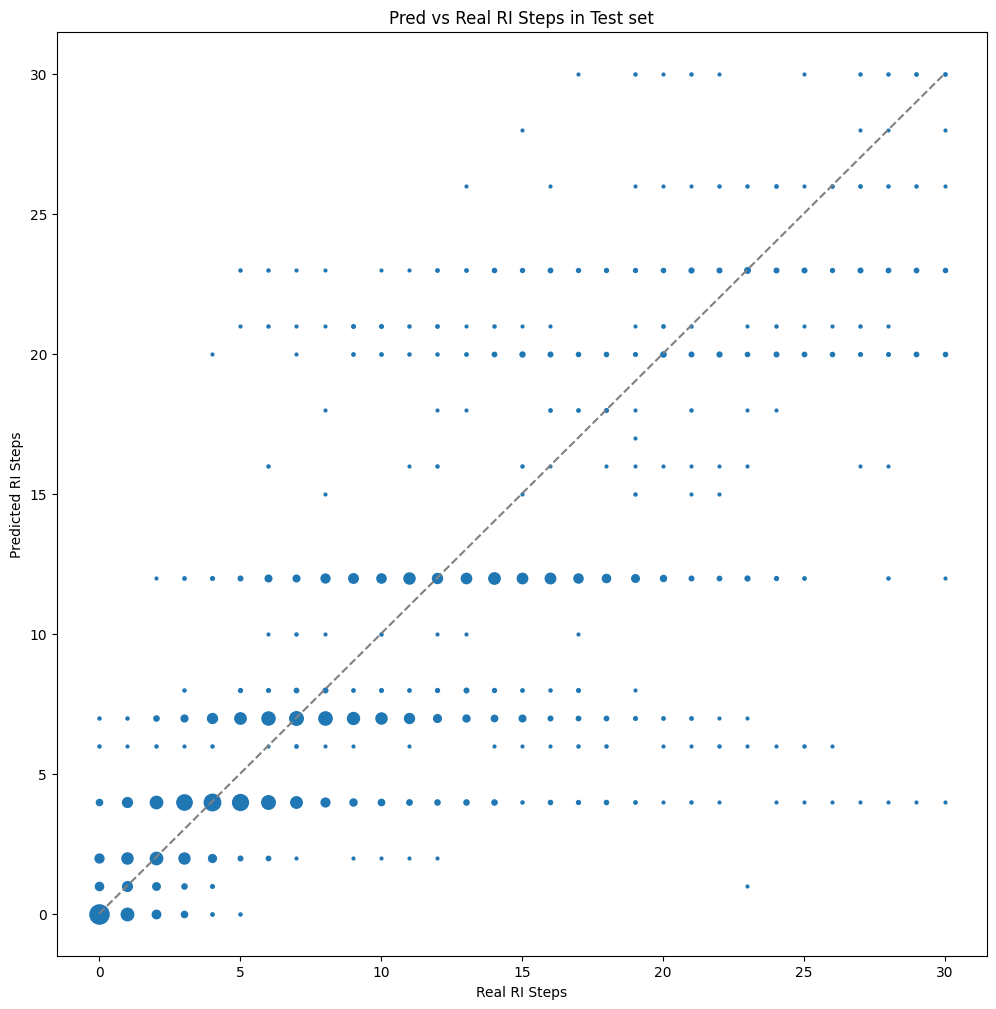

In [30]:
def draw_pred_scatter(y_real, y_pred, title="Train dataset", axis_name="RI Steps"):
    counter = Counter([(x_, y_) for x_, y_ in zip(y_real, y_pred)])
    coords_count = dict(counter)

    plt.figure(figsize=(12, 12))

    coords_count_rev = dict()
    for key_, val_ in coords_count.items():
        if val_ not in coords_count_rev:
            coords_count_rev[val_] = []
        coords_count_rev[val_].append(key_)

    tcoords_count_rev = dict()
    for key_ in sorted(coords_count_rev.keys()):
        tcoords_count_rev[key_] = coords_count_rev[key_]

    coords_count_rev = tcoords_count_rev

    for key_, val_ in coords_count_rev.items():
        coords_data = np.array(val_)
        plt.scatter(coords_data[:, 0], coords_data[:, 1], s=key_ ** 1 + 3, c='tab:blue', label=f"\n{key_}\n")
    plt.plot([0, 30], [0, 30], color='gray', linestyle='--')

    plt.xlabel(f"Real {axis_name}")
    plt.ylabel(f"Predicted {axis_name}")
    plt.title(f"Pred vs Real {axis_name} in {title}")
    plt.show()


draw_pred_scatter(y_train_nums, y_train_cl_pred_nums, "Train set", "RI Steps")
draw_pred_scatter(y_test_nums, y_test_cl_pred_nums, "Test set", "RI Steps")

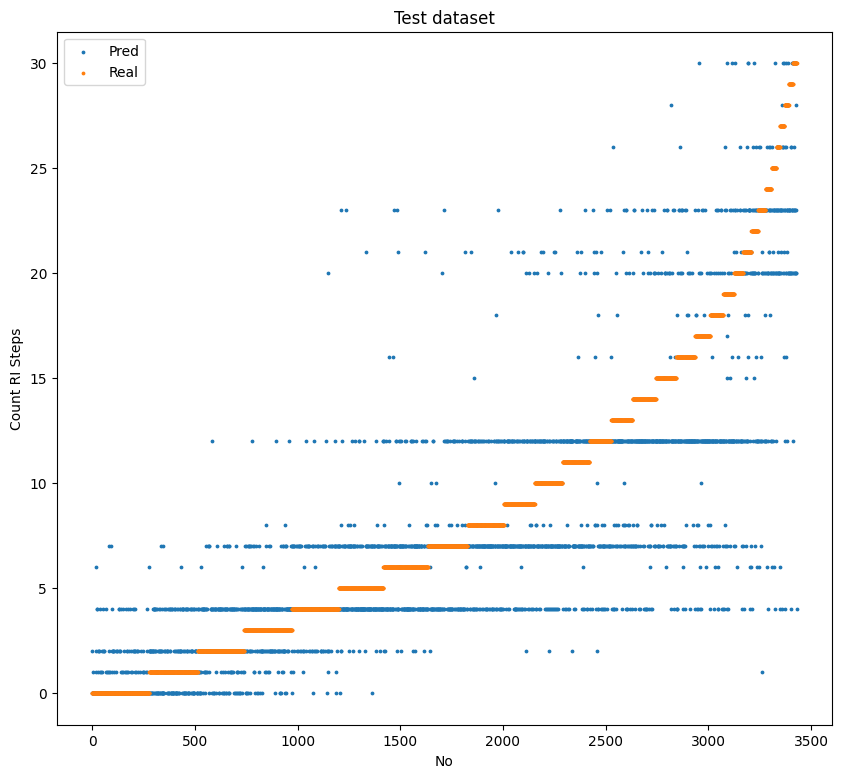

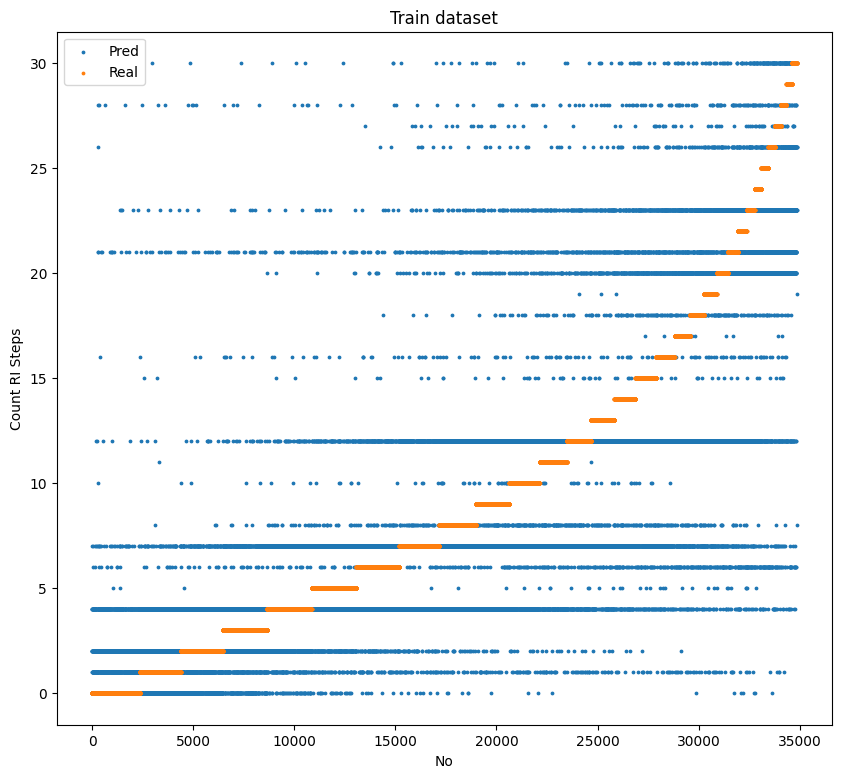

In [31]:
def draw_pred_lines(y_pred, y_real, title="Train dataset", axis_name="RI Steps"):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.scatter(range(len(val_)), val_, label=key_, s=3)

    plt.xlabel("No")
    plt.ylabel(f"Count {axis_name}")
    plt.title(title)
    plt.legend()
    plt.show()


rcParams["figure.figsize"] = 10, 9
draw_pred_lines(y_test_pred_nums, y_test_nums, title="Test dataset", axis_name="RI Steps")
draw_pred_lines(y_train_pred_nums, y_train_nums, title="Train dataset", axis_name="RI Steps")

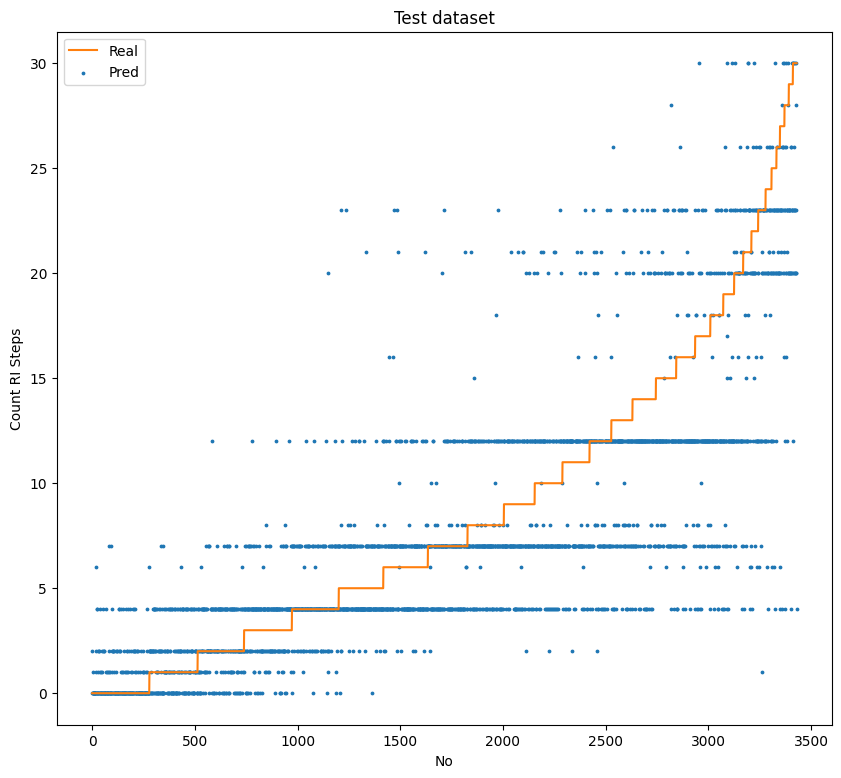

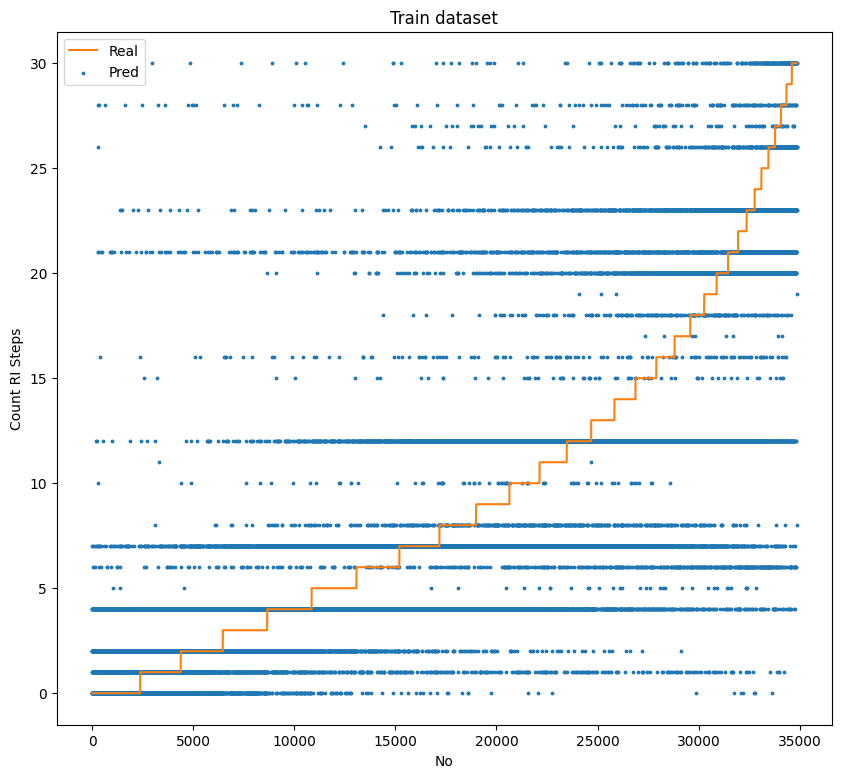

In [32]:
def draw_pred_lines(y_pred, y_real, title="Train dataset", axis_name="RI Steps"):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    plt.plot(range(len(drawing_df["Real"])), drawing_df["Real"], label="Real", c=colors[1])
    plt.scatter(range(len(drawing_df["Pred"])), drawing_df["Pred"], label="Pred", s=3, c=colors[0])

    plt.xlabel("No")
    plt.ylabel(f"Count {axis_name}")
    plt.title(title)
    plt.legend()
    plt.show()


rcParams["figure.figsize"] = 10, 9
draw_pred_lines(y_test_pred_nums, y_test_nums, title="Test dataset", axis_name="RI Steps")
draw_pred_lines(y_train_pred_nums, y_train_nums, title="Train dataset", axis_name="RI Steps")